In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df=pd.read_csv("/content/monthly_milk_production.csv",index_col='Date',parse_dates=True)
df.index.freq='MS'
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


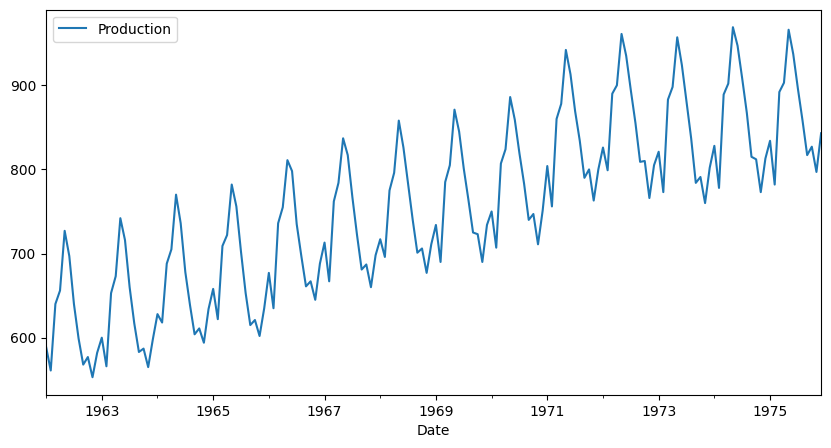

In [11]:
df.plot(figsize=(10,5))
plt.show()

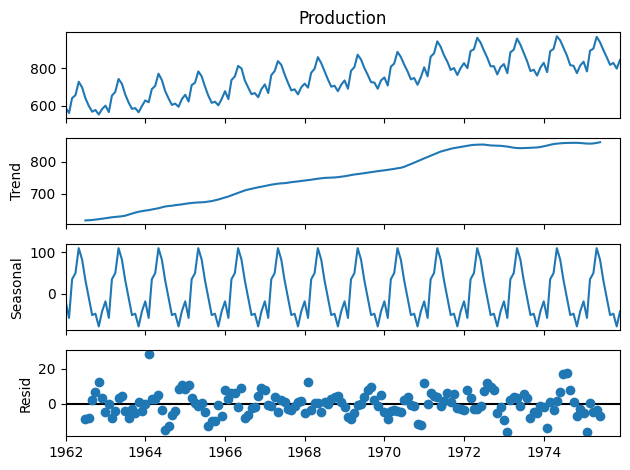

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['Production'])
result.plot();

In [18]:
len(df)

168

In [19]:
train=df.iloc[:156]
test=df.iloc[156:]


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()


In [21]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [22]:
scaler.fit(train)
train_scaled=scaler.transform(train)
test_scaled=scaler.transform(test)

In [23]:
train_scaled[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [25]:
#define generator
from keras.preprocessing.sequence import TimeseriesGenerator
n_input=3
n_output=1
generator=TimeseriesGenerator(train_scaled,train_scaled,length=n_input,batch_size=1)

In [26]:
x,y=generator[0]
print("given the array:",x.flatten())
print("predict this y:",y)

given the array: [0.08653846 0.01923077 0.20913462]
predict this y: [[0.24759615]]


In [27]:
x.shape

(1, 3, 1)

In [28]:
#we do the same thing but we areusing 12 months
n_input=12
n_output=1
generator=TimeseriesGenerator(train_scaled,train_scaled,length=n_input,batch_size=1)

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
#define model
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_output)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
144/144 [==============================] - 7s 9ms/step - loss: 0.0441
Epoch 2/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0218
Epoch 3/100
144/144 [==============================] - 1s 8ms/step - loss: 0.0166
Epoch 4/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0119
Epoch 5/100
144/144 [==============================] - 2s 13ms/step - loss: 0.0069
Epoch 6/100
144/144 [==============================] - 2s 13ms/step - loss: 0.0073
Epoch 7/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 8/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 9/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 10/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 11/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 12/100
144/144 [==============================] - 2s 11ms/step - loss: 0.0044
Epoch 13/1

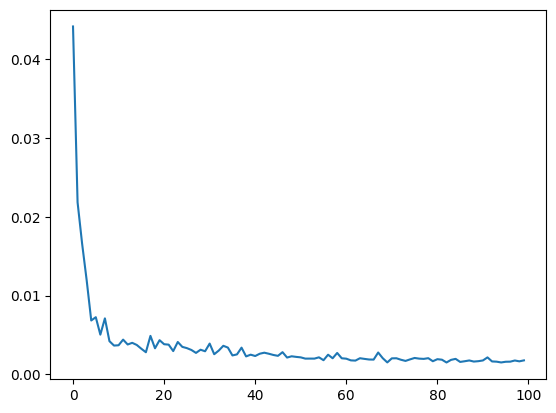

In [34]:
#fit model
model.fit(generator,epochs=100)
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [38]:
last_train_batched=train_scaled[-12:]
last_train_batch=last_train_batched.reshape(1,n_input,n_output)
model.predict(last_train_batch)

1/1 [==============================] - 0s 218ms/step


array([[0.6482485]], dtype=float32)

In [39]:
test_scaled[0]

array([0.67548077])

In [41]:
test_prediction=[]

In [42]:
first_eval_batch=test_scaled[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_output))

In [44]:
for i in range(len(test)):
    #get the prediction value for the first batch
    current_pred=model.predict(current_batch)[0]
    #append the prediction into the array
    test_prediction.append(current_pred)
    #use the predictiion to  update and remove the first value
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 37ms/step


In [45]:
test_prediction

[array([0.6751552], dtype=float32),
 array([0.6137121], dtype=float32),
 array([0.7818221], dtype=float32),
 array([0.81852406], dtype=float32),
 array([0.9443806], dtype=float32),
 array([0.9072708], dtype=float32),
 array([0.84389895], dtype=float32),
 array([0.7540984], dtype=float32),
 array([0.6651939], dtype=float32),
 array([0.65146315], dtype=float32),
 array([0.6026413], dtype=float32),
 array([0.6741647], dtype=float32)]

In [46]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [47]:
true_predictions=scaler.inverse_transform(test_prediction)

In [48]:
test['Predictions']=true_predictions

<ipython-input-48-37e263692d24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predictions


<Axes: xlabel='Date'>

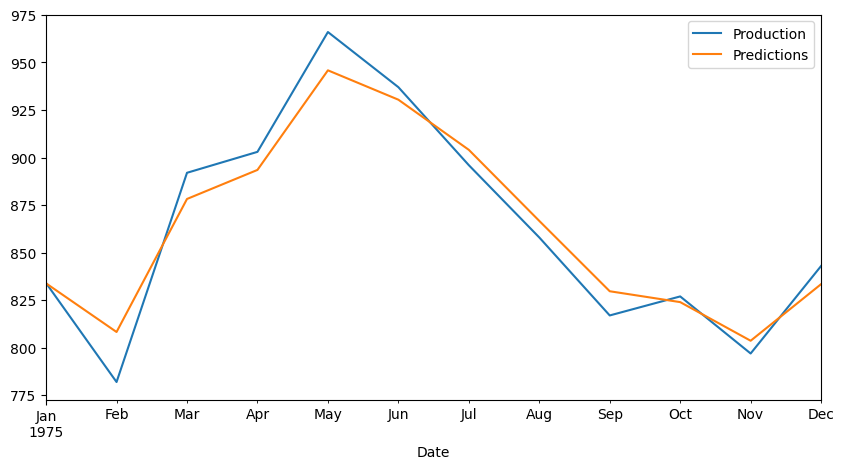

In [49]:
test.plot(figsize=(10,5))

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

12.475921052536693
